In [266]:
import os

import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from typing import *
from datetime import datetime
from dateutil.parser import parse
import requests

## Read the CSV in

The converters thing is so 'genres' are actually a list, and not a blob of text

In [267]:
df = pd.read_csv("books.csv", converters={"genres": eval})
df = df.drop('Unnamed: 0', 1)

In [241]:
df.head()

,title,author,rating,date,genres
0,How to win friends and influence people,Dale Carnegie,2.0,2018-01-29,"[management, non-fiction, self-help]"
1,Fire and Fury,Michael Wolff,2.0,2018-01-29,"[non-fiction, politics]"
2,The Leopard,Jo Nesbo,3.0,2018-01-29,"[fiction, scandi noir]"
3,Killing & Dying,Adrian Tomine,4.0,2018-01-29,"[fiction, graphic novel]"
4,Lagom,Linea Dunne,3.0,2018-01-30,"[non-fiction, self-help]"


## Books read per year

2021 has just begun!

<AxesSubplot:xlabel='year'>

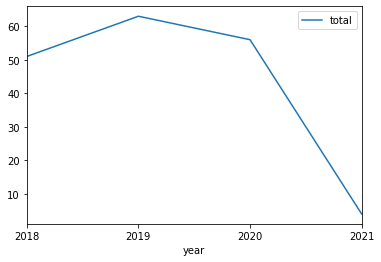

In [235]:
bpy = pd.read_csv("books_per_year.csv")
bpy.columns = ['year', 'total']
bpy.index = pd.to_datetime(bpy.year, format='%Y')
bpy = bpy.drop('year', axis=1)
bpy.plot()

## Rating Distribution
Maybe I'm too generous

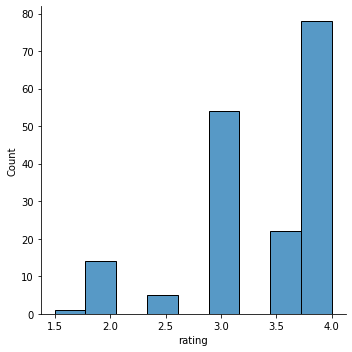

In [236]:
sns.displot(df, x="rating")

## Top 10 Most Popular Authors
This includes duplicates, but I figure it still makes them popular.

In [243]:
df.groupby('author').count().sort_values('title', ascending=False).head(10).title

author
Jo Nesbo             10
JK Rowling            8
John Green            5
Andrzej Sapkowski     5
HP Lovecraft          5
Henning Mankell       4
Clive Hamilton        4
Brian Jacques         3
Meik Wiking           3
Mark Manson           3
Name: title, dtype: int64

## Ratings over time

Interestingly it would appear that as time goes by, I tend to rate books higher. 
A few hypotheses might be:
  * I'm pickier
  * I stop reading books I don't enjoy (and don't finish and catalogue them)
  
Also looks like as the year drags on, I start reading less enjoyable things!

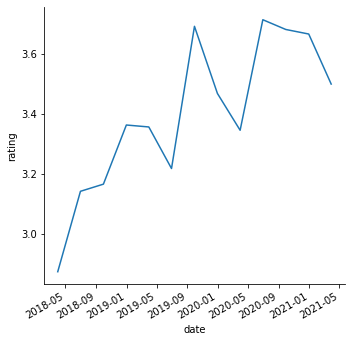

In [238]:
df_ratings = df.set_index('date')
df_ratings.index = pd.to_datetime(df_ratings.index)
df_ratings = df_ratings.resample('1Q').mean()
g = sns.relplot(x='date', y='rating', data=df_ratings, kind='line')
g.fig.autofmt_xdate()

## Books read multiple times

A personal unspoken sort-of rule is not to read the same book twice in year, but it's ok once a new year has rolled over.

What's interesting here is:
  * Ratings changing after a re-read
  * Majority of them are rated quite high, which would explain the re-read

In [242]:
df_dups = df.set_index('date')
df_dups[df_dups.duplicated(['title'], keep=False)].sort_values(['title', 'date', 'rating'])

,title,author,rating,genres
date,,,,
2018-10-01,A Higher Loyalty,James Comey,4.0,"[biographical, non-fiction, politics]"
2019-05-16,A Higher Loyalty,James Comey,4.0,"[biographical, non-fiction, politics]"
2018-09-09,Affluenza,Clive Hamilton,3.0,"[finance, non-fiction, politics]"
2019-12-20,Affluenza,Clive Hamilton,3.5,"[finance, non-fiction, politics]"
2018-07-26,Believe Me,Eddie Izzard,4.0,"[biographical, non-fiction]"
2019-01-22,Believe Me,Eddie Izzard,3.0,"[biographical, non-fiction]"
2018-07-29,Bullshit Jobs,David Graeber,4.0,"[business, non-fiction]"
2020-05-31,Bullshit Jobs,David Graeber,3.5,"[business, non-fiction]"
2018-06-18,Burma Chronicles,Guy Delisle,4.0,"[graphic novel, non-fiction, travel]"


# Genre

## Fiction vs Non-fiction
Each book is tagged with one or more genres, and always has at least fiction or non-fiction

In [436]:
from collections import Counter
fnf = Counter([i for l in df.genres.tolist() for i in l if i in ("non-fiction", "fiction")])
nf = fnf["non-fiction"]
f = fnf["fiction"]

In [441]:
print(f"Percentage non-fiction: {round(nf / (f + nf) * 100)}%")

Percentage non-fiction: 56%


In [442]:
print(f"Percentage fiction: {round(f / (f + nf) * 100)}%")

Percentage fiction: 44%


## Fiction vs Non-fiction over time

Does the occurrence change much over the last few years?

* I was heavily skewed towards non-fiction in 2019 but it seems like a good blend at the moment!

In [280]:
def genre_counts(a_df, freq: str = 'M', genre_filter: Optional[List[str]] = None):
    df = a_df.explode("genres").drop(["title", "author", "rating"], axis=1)
    df = df.set_index('date', drop=False)
    df.index = pd.to_datetime(df.index)
    df = df.groupby([pd.Grouper(freq=freq), 'genres']).count().unstack(fill_value=0).stack()
    df.index = df.index.rename(['month', 'genres'])
    df = df.reset_index().set_index("month")
    df.columns = ['genres', 'count']
    if genre_filter:
        df = df[df.genres.isin(genre_filter)]
    return df

In [281]:
fnf_data = genre_counts(df, genre_filter=['fiction', 'non-fiction'])

fig = px.line(fnf_data, x=fnf_data.index, y="count", color="genres", title='Fiction vs Non-fiction over time')
fig.show()

## Top 10 Genres

In [173]:
by_genre = Counter([i for l in df.genres.tolist() for i in l if i not in ("non-fiction", "fiction")])

In [174]:
by_genre.most_common(10)

[('fantasy', 29),
 ('self-help', 28),
 ('biographical', 18),
 ('management', 16),
 ('scandi noir', 16),
 ('programming', 14),
 ('politics', 13),
 ('technology', 13),
 ('classic', 12),
 ('business', 12)]

## Comparing genre popularity over time

This won't appear in the Github preview, but plotly allows you to filter out certain categories

In [284]:
genres_to_show = ['self-help']
genre_data = genre_counts(df, genre_filter=genres_to_show)
if genre_data.empty:
    print(f"Nothing for that filter: {genres_to_show}")
else:
    fig = px.line(genre_data, x=genre_data.index, y="count", color="genres", title="Comparing genres over time")
    fig.show()

## Calculate the delta between each read

Sometimes I don't add cards consistently, but for the most part it's fairly accurate. Note that when I started the list in 2018, I added bunch all at once (having remembered what I had read in that month)

### Things of note:
  * The huge spike in April 2018 is when I was going through a bit of a blue period, and didn't really read that much. It's a gap between reading 'The Invisible Man' (H.G. Wells) and 'Effortless Mastery' (Kenny Werner). 
  * The next spike in 2019 was when I read the Alan Turing biography. It's pretty dense and took about a month!

In [229]:
df_dd = df.set_index('date')
df_dd.index = pd.to_datetime(df_dd.index)

df_dd['tvalue'] = df_dd.index
df_dd['delta'] = (df_dd['tvalue']-df_dd['tvalue'].shift()).fillna(pd.Timedelta(seconds=0))
df_dd["delta"] = df_dd['delta'].apply(lambda x: int(str(x).split(' ')[0]))
df_dd = df_dd.drop(["rating", "genres", "tvalue"], axis=1)

fig = px.line(df_dd, x=df_dd.index, y="delta", title="Time in days between each book")
fig.show()

,title,author,delta
date,,,
2018-01-29,How to win friends and influence people,Dale Carnegie,0
2018-01-29,Fire and Fury,Michael Wolff,0
2018-01-29,The Leopard,Jo Nesbo,0
2018-01-29,Killing & Dying,Adrian Tomine,0
2018-01-30,Lagom,Linea Dunne,1
...,...,...,...
2020-12-28,The Unicorn Project,Gene Kim,2
2021-01-01,The Goal,E.M. Goldratt,4
2021-01-04,The Delicate Art of Bureaucracy,Mark Schwartz,3


In [257]:
adf = df.explode("genres").drop(["title", "author", "rating"], axis=1)
adf = adf.set_index('date', drop=False)
adf.index = pd.to_datetime(adf.index)
adf = adf.groupby([pd.Grouper(freq='D'), 'genres']).count().unstack(fill_value=0).stack()
adf.index = adf.index.rename(['month', 'genres'])
adf = adf.reset_index().set_index("month")
adf.columns = ['genres', 'count']
adf

,genres,count
month,,
2018-01-29,astronomy,0
2018-01-29,biographical,0
2018-01-29,biology,0
2018-01-29,business,0
2018-01-29,classic,0
...,...,...
2021-01-14,technology,0
2021-01-14,thriller,0
2021-01-14,travel,0


In [258]:
adf[adf['count'] == 0]

,genres,count
month,,
2018-01-29,astronomy,0
2018-01-29,biographical,0
2018-01-29,biology,0
2018-01-29,business,0
2018-01-29,classic,0
...,...,...
2021-01-14,technology,0
2021-01-14,thriller,0
2021-01-14,travel,0
